STEP - 1: DATA EXPLORATION AND SETUP

In [17]:

# Load all required Libraries
import pandas as pd
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset

import faiss
import numpy as np

In [3]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")

print(passages.shape)
passages.head()

(3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


# EDA on the passage dataset
- Check for missing values
- Check for Duplicates
- Max and min length of passages

In [4]:
# Printing basic information
print("Shape:", passages.shape)
print("\nColumns:", passages.columns.tolist())
print("\nFirst sample:\n", passages.iloc[0]["passage"])

Shape: (3200, 1)

Columns: ['passage']

First sample:
 Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in the capital Montevideo and its metropolitan area.


In [5]:
# Checking for Missing values
print("\nMissing values:\n", passages.isna().sum())


Missing values:
 passage    0
dtype: int64


In [6]:
print(passages.shape)
# Checking for Duplicates
duplicate_count = passages.duplicated(subset=["passage"]).sum()
print("\nDuplicate passages:", duplicate_count)

#Removing duplicates
passages = passages.drop_duplicates(subset=["passage"])
print("New shape after dropping duplicates:", passages.shape)

(3200, 1)

Duplicate passages: 4
New shape after dropping duplicates: (3196, 1)


In [7]:
# Calculating length of passages
passages["len_tokens"] = passages["passage"].str.split().str.len()

print("\nPassage length stats:\n", passages["len_tokens"].describe())


Passage length stats:
 count    3196.000000
mean       62.175219
std        55.419487
min         1.000000
25%        17.000000
50%        48.000000
75%        92.000000
max       425.000000
Name: len_tokens, dtype: float64


In [10]:
print("\nShortest passage:\n", passages.loc[passages["len_tokens"].idxmin(), "passage"])
print("\nLongest passage:\n", passages.loc[passages["len_tokens"].idxmax(), "passage"])


Shortest passage:
 125px

Longest passage:
 As Ford approached his ninetieth year, he began to experience significant health problems associated with old age. He suffered two minor strokes at the 2000 Republican National Convention, but made a quick recovery.  Gerald Ford recovering after strokes. BBC, August 2, 2000.  Retrieved on December 31, 2006.  In January 2006, he spent 11 days at the Eisenhower Medical Center near his residence at Rancho Mirage, California, for treatment of pneumonia.  Former President Ford, 92, hospitalized with pneumonia. Associated Press, January 17, 2006. Retrieved on October 19, 2007.  On April 23, President George W. Bush visited Ford at his home in Rancho Mirage for a little over an hour. This was Ford's last public appearance and produced the last known public photos, video footage and voice recording. While vacationing in Vail, Colorado, he was hospitalized for two days in July, 2006 for shortness of breath.  Gerald Ford released from hospital. Associ

Matplotlib is building the font cache; this may take a moment.


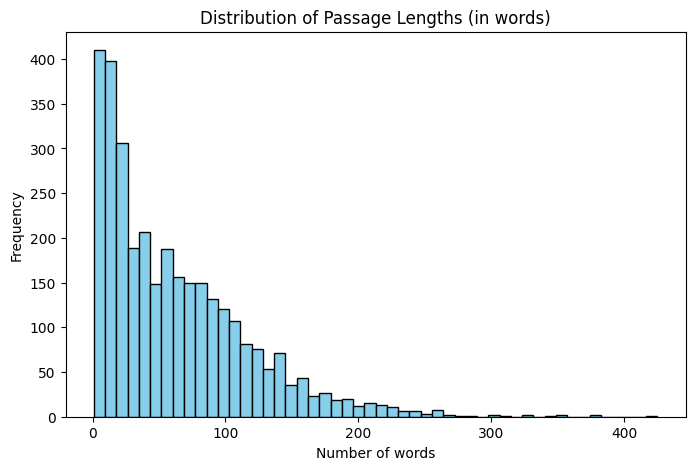

In [8]:
# Plotting histogram of passage lengths

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(passages["len_tokens"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Passage Lengths (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Save cleaned passages
passages.to_parquet("../data/processed/passages_clean.parquet", index=False)
print("Saved cleaned passages to data/processed/passages_clean.parquet")

Saved cleaned passages to data/processed/passages_clean.parquet


# Basic analysis of the test data

In [12]:
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet").dropna(subset=["question", "answer"])
df_test = df_test.reset_index(drop=True)

In [13]:
df_test.head()

,question,answer
0,Was Abraham Lincoln the sixteenth President of...,yes
1,Did Lincoln sign the National Banking Act of 1...,yes
2,Did his mother die of pneumonia?,no
3,How many long was Lincoln's formal education?,18 months
4,When did Lincoln begin his political career?,1832


In [ ]:
# Calculating length of answers
df_test["len_tokens"] = df_test["answer"].str.split().str.len()

print("\Answer length stats:\n", df_test["len_tokens"].describe())

\Answer length stats:
 count    918.000000
mean       3.377996
std        5.511942
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max       65.000000
Name: len_tokens, dtype: float64


In [ ]:
#Printing shortest and longest answers
print("\nShortest passage:\n", df_test.loc[df_test["len_tokens"].idxmin(), "answer"])
print("\nLongest passage:\n", df_test.loc[df_test["len_tokens"].idxmax(), "answer"])


Shortest passage:
 yes

Longest passage:
 Howling helps pack members keep in touch, allowing them to communicate effectively in thickly forested areas or over great distances. Howling also helps to call pack members to a specific location. Howling can also serve as a declaration of territory, as shown in a dominant wolf&apos;s tendency to respond to a human imitation of a "rival" wolf in an area the wolf considers its own. 


In [9]:
df_test.describe

<bound method NDFrame.describe of                                               question  \
0    Was Abraham Lincoln the sixteenth President of...   
1    Did Lincoln sign the National Banking Act of 1...   
2                     Did his mother die of pneumonia?   
3        How many long was Lincoln's formal education?   
4         When did Lincoln begin his political career?   
..                                                 ...   
913  Was Wilson president of the American Political...   
914  Did he not cast his ballot for John M. Palmer ...   
915  Did Wilson not spend 1914 through the beginnin...   
916  Was Wilson , a staunch opponent of antisemitis...   
917                             What happened in 1917?   

                                                answer  
0                                                  yes  
1                                                  yes  
2                                                   no  
3                                        